In [1]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# ---------------------------------------------------------
# Load MFCC file safely
# ---------------------------------------------------------
def load_mfcc(path):
    try:
        return np.genfromtxt(path, delimiter=',', dtype=float)
    except Exception as e:
        print(f"[ERROR] Failed to load MFCC {path}: {e}")
        return None

In [3]:
# ---------------------------------------------------------
# Extract true language using filename prefix
# Example: Ar_H_1_10s_3.mfcc → "Ar"
# ---------------------------------------------------------
def get_true_language(filename):
    prefix = filename.split("_")[0]  # Ar, En, Fr, Sp...
    
    lang_map = {
        "Ar": "Arabic",
        "En": "English",
        "Fr": "French",
        "Sp": "Spanish",
        "Jp": "Japanese",
        "Gr": "German"
        # add any other languages here
    }
    
    return lang_map.get(prefix, "Unknown")

In [4]:
def load_all_models(model_root):
    all_models = {}

    for lang in os.listdir(model_root):
        lang_dir = os.path.join(model_root, lang)
        if not os.path.isdir(lang_dir): 
            continue

        all_models[lang] = {}

        for file in os.listdir(lang_dir):
            if file.endswith(".gmm"):
                comp = file.split("_")[-1].replace(".gmm", "")  # Extract "4", "8"...
                path = os.path.join(lang_dir, file)

                try:
                    all_models[lang][comp] = joblib.load(path)
                except Exception as e:
                    print(f"[ERROR] Failed loading {file}: {e}")

    return all_models

In [5]:
# ---------------------------------------------------------
# Save confusion matrix to image
# ---------------------------------------------------------
def plot_confusion_matrix_ax(ax, y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        cbar=False
    )
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")


In [6]:
# ---------------------------------------------------------
# Test all models globally:
# For each duration (5s,10s,15s)
# For each file → compare against ALL languages
# ---------------------------------------------------------
def test_models(mfcc_root, model_root):
    languages = [d for d in os.listdir(mfcc_root)
                 if os.path.isdir(os.path.join(mfcc_root, d))]

    print("\nLanguages detected:", languages)

    # Load ALL models (all langs, all components)
    all_models = load_all_models(model_root)

    # Durations to test
    durations = ["5s", "10s", "15s"]

    # Loop through GMM components
    example_lang = languages[0]
    components = list(all_models[example_lang].keys())

    print("\nGMM components:", components)

    # ======================================================
    #  MAIN EVALUATION LOOP
    # ======================================================
    for comp in components:
        print(f"\n=== Testing component: {comp} ===")

        fig, axes = plt.subplots(1, len(durations), figsize=(18, 6))
        fig.suptitle(f"Confusion Matrices — {comp} components", fontsize=14)

        for idx, dur in enumerate(durations):

            y_true = []
            y_pred = []

            # Loop across all languages’ test sets
            for lang in languages:

                for gender in ["Male", "Female"]:
                    test_path = os.path.join(mfcc_root, lang, gender, "test")
                    if not os.path.exists(test_path):
                        continue

                    for file in os.listdir(test_path):
                        if not (file.endswith(".mfcc") and dur in file):
                            continue

                        mfcc_file = os.path.join(test_path, file)
                        mfcc = load_mfcc(mfcc_file)
                        if mfcc is None:
                            continue

                        true_lang = get_true_language(file)
                        if true_lang not in languages:
                            true_lang = "Unknown"

                        # Evaluate against ALL LANGUAGES MODELS
                        best_score = -np.inf
                        predicted_lang = "Unknown"

                        for lang_model_name in all_models.keys():
                            model = all_models[lang_model_name].get(comp)
                            if model is None:
                                continue

                            try:
                                score = model.score(mfcc)

                                if score > best_score:
                                    best_score = score
                                    predicted_lang = lang_model_name
                            except:
                                pass  # Ignore scoring errors

                        # Save results
                        y_true.append(true_lang)
                        y_pred.append(predicted_lang)

            # ======================================================
            #  CREATE CONFUSION MATRIX
            # ======================================================
            labels = sorted(languages)

            plot_confusion_matrix_ax(
            axes[idx],
            y_true,
            y_pred,
            labels,
            title=f"{dur}"
            )

        plt.tight_layout(rect=[0, 0, 1, 0.92])
        plt.show()


Languages detected: ['Arabic', 'English', 'French', 'German', 'Japanese', 'Spanish']

GMM components: ['128', '16', '256', '32', '4', '512', '64', '8']

=== Testing component: 128 ===


C:\Users\ahnta\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


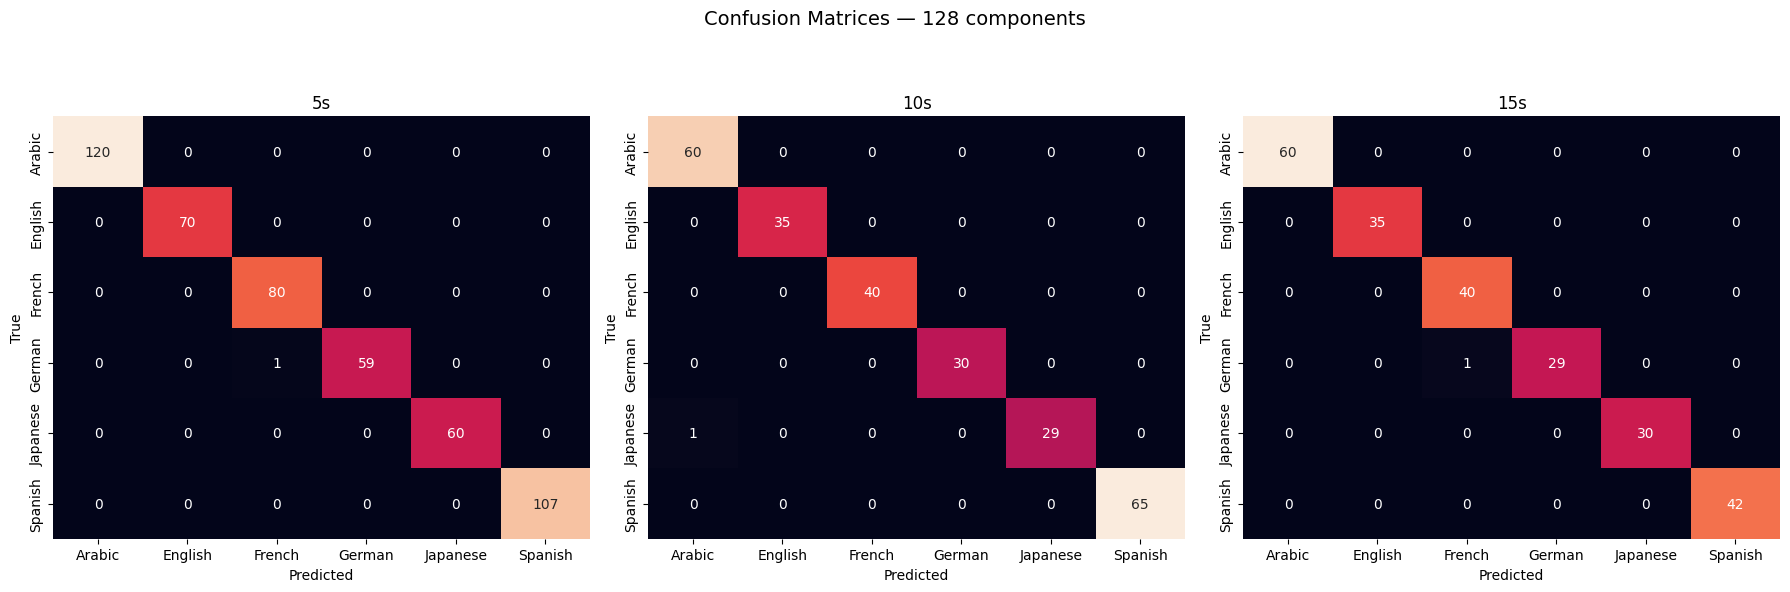


=== Testing component: 16 ===


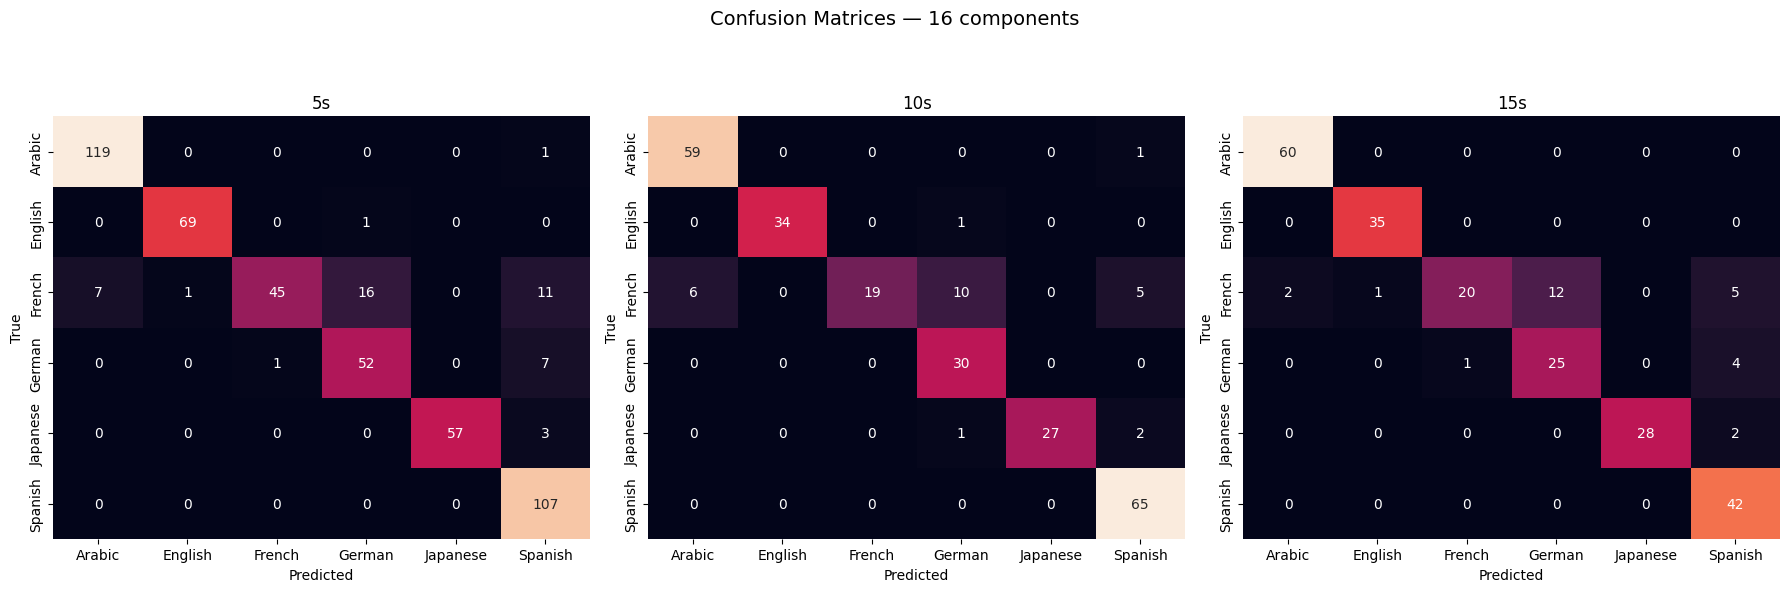


=== Testing component: 256 ===


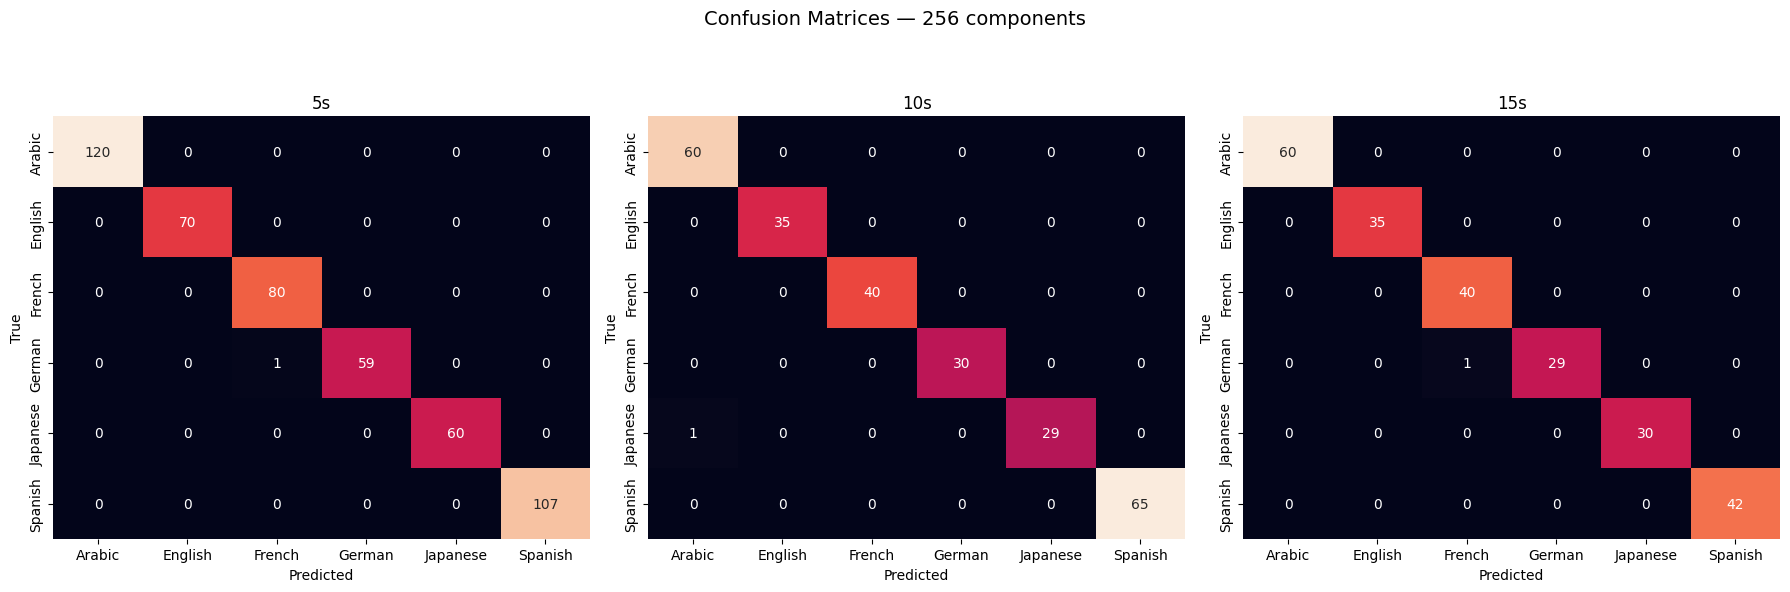


=== Testing component: 32 ===


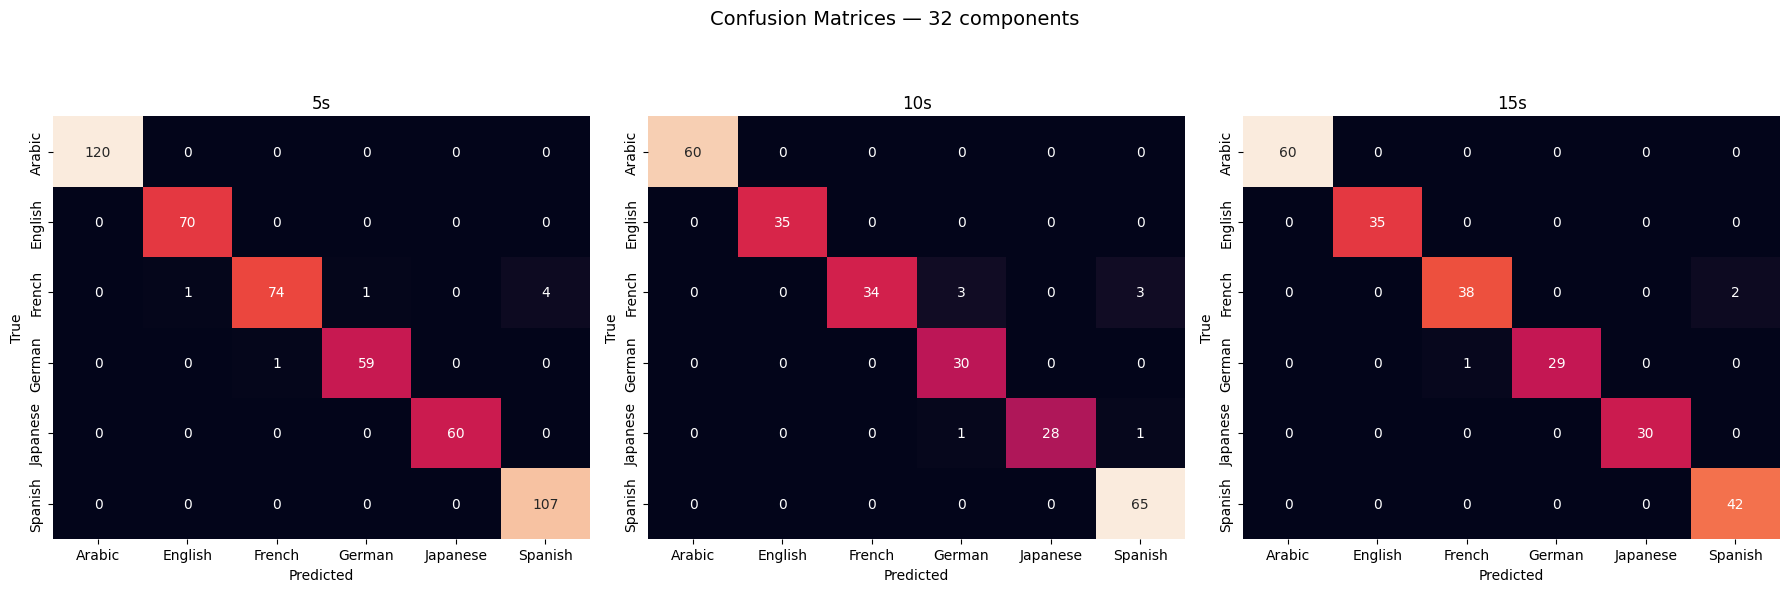


=== Testing component: 4 ===


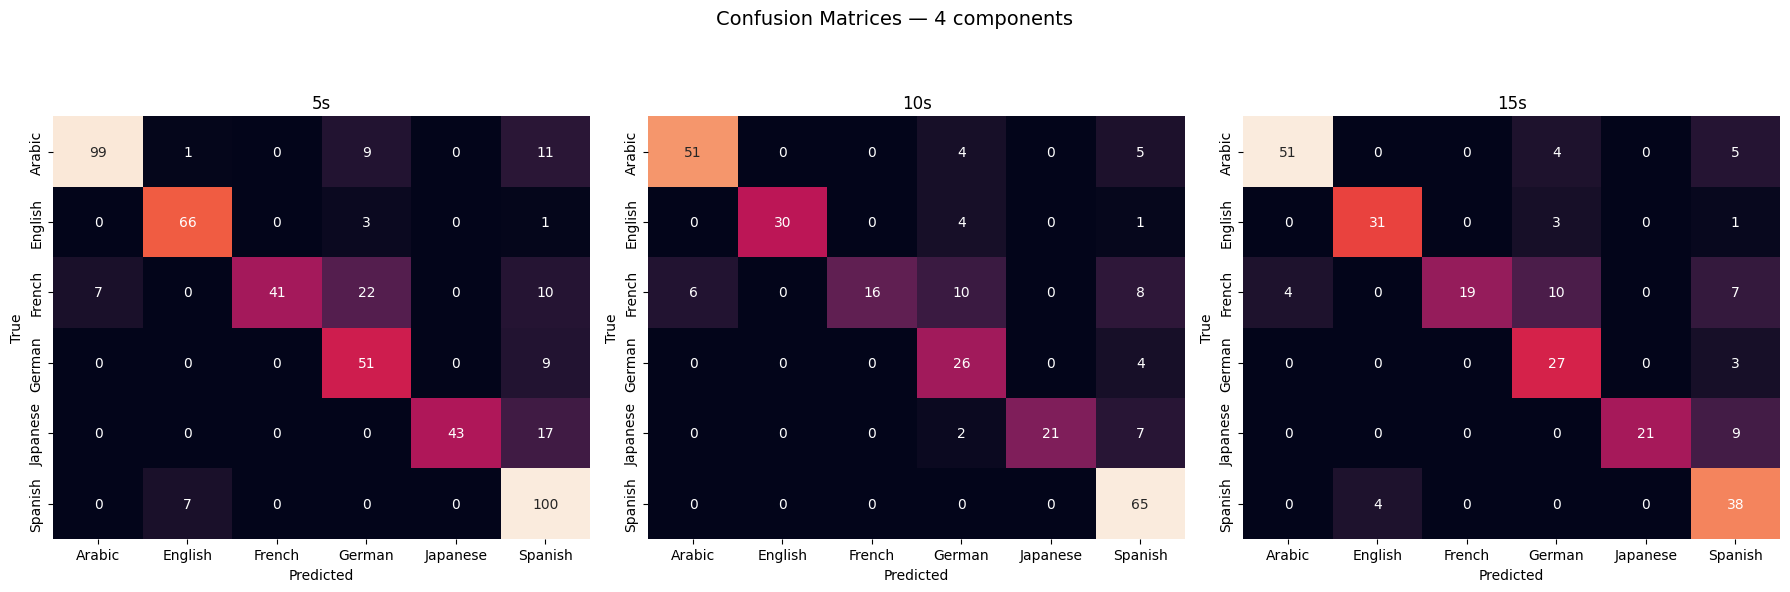


=== Testing component: 512 ===


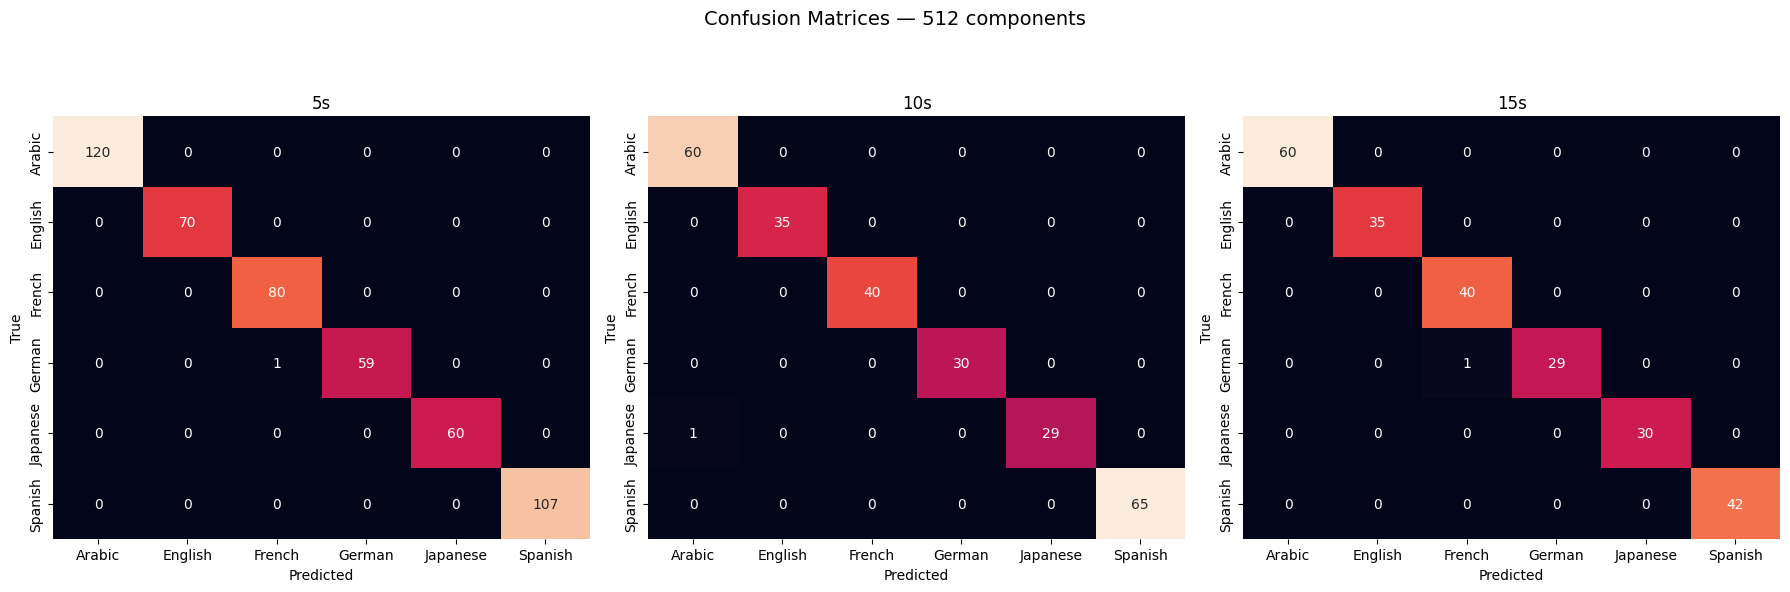


=== Testing component: 64 ===


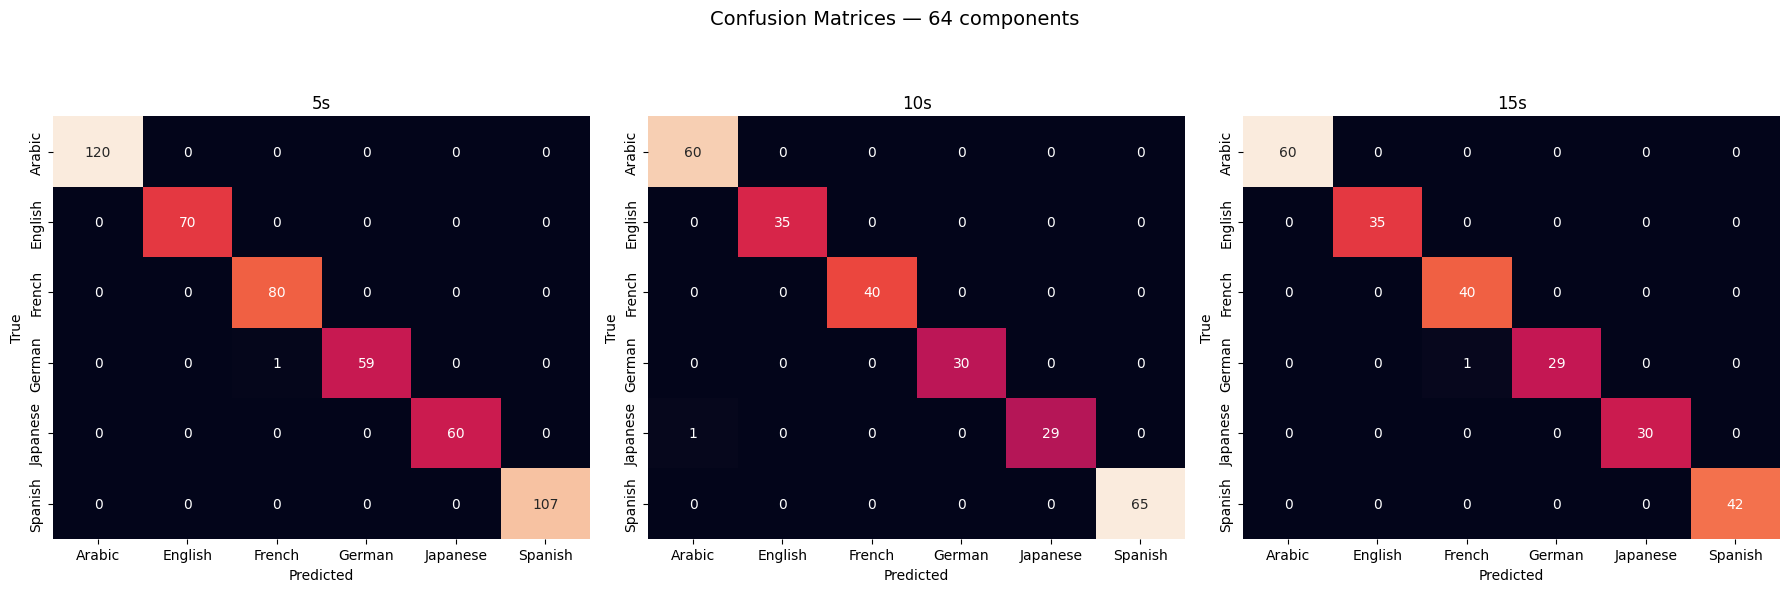


=== Testing component: 8 ===


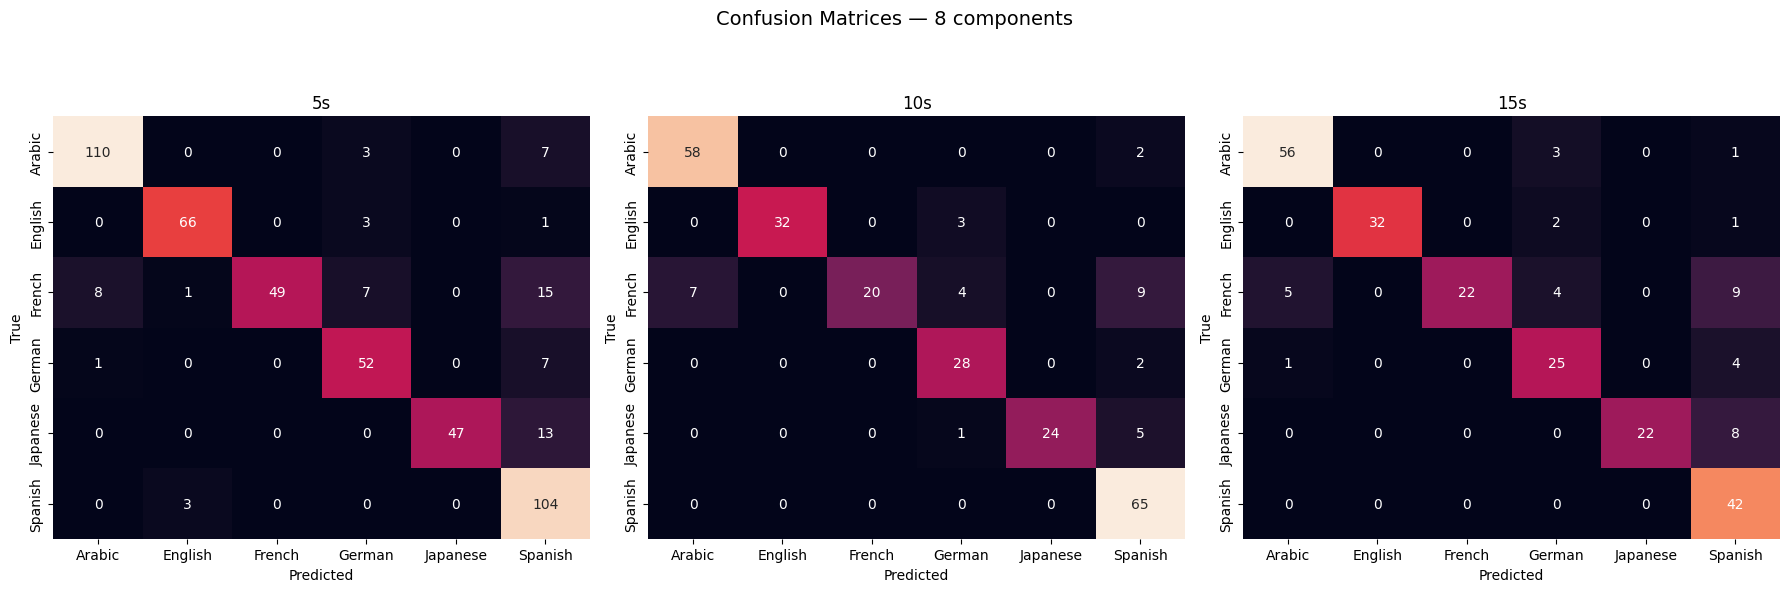

In [7]:
mfcc_root = r"C:\Users\ahnta\Desktop\Audio_Databse\MFCC"
model_root = r"C:\Users\ahnta\Desktop\Audio_Databse\GMM_Models"

test_models(mfcc_root, model_root)